# Parameter Recovery
---
This notebook is for generating figure 2 of: $\textit{A Hidden Markov Model with Drift Diffusion Model
Emissions (HMM-DDM) for the Analysis of Animal Choice Data}$

In [83]:
# load required libraries
using DriftDiffusionModels
using Random
using Distributions
using Base.Threads: @threads
using HiddenMarkovModels
using JLD2
using LinearAlgebra
using Plots
using Printf
using StatsBase

## Shared Parameters

This set of code will define the parameters that are shared across the "high", "medium" and "low" separation experiments.

In [16]:
# Transition matrix and initial state distribution
A = [0.95 0.05; 0.2 0.8]
π₀ = [0.89, 0.11];

t_lengths = [10, 100, 1000, 1000, 10000, 100000]

# Starting conditions for the HMM
A_guess = [0.9 0.1; 0.1 0.9]
π₀_guess = [1.0, 0.0];

# Helper function to create an hmm from two ddms 
function make_hmm(ddm1::DriftDiffusionModel, ddm2::DriftDiffusionModel; A=A, π₀=π₀)
    PriorHMM(π₀, A, [ddm1, ddm2], ones(2, 2) .* 2, ones(2))
end

# Create a thread lock here
dict_lock = ReentrantLock()

# Prepare combinations
models = ["high", "medium", "low"]
combinations = collect(Iterators.product(models, t_lengths))

3×6 Matrix{Tuple{String, Int64}}:
 ("high", 10)    ("high", 100)    ("high", 1000)    …  ("high", 100000)
 ("medium", 10)  ("medium", 100)  ("medium", 1000)     ("medium", 100000)
 ("low", 10)     ("low", 100)     ("low", 1000)        ("low", 100000)

## Create DDMs
This cell creates the DDMs used in our experiment. We will create a high, mopderate, and low separated DDM, corresponding to how similar the emission models are.

In [22]:
# this part will define the DDMs for our experiment. In these models v is drift rate, B is boundary separation, and τ is non-decision time. We assume the initial state (defined as the relative fraction between correct and wrong choice is 0.5, i.e., unbiased), we also assume the noise coefficient σ = 1.0.
engaged_ddm = DriftDiffusionModel(
    v = 0.5,
    B = 3.0,
    τ = 0.3
)

also_engaged_ddm = DriftDiffusionModel(
    v = 0.4,
    B = 2.8,
    τ = 0.25
)

less_engaged_ddm = DriftDiffusionModel(
    v = 0.5,
    B = 2.0,
    τ = 0.35
)

disengaged_ddm = DriftDiffusionModel(
    v = 0.1,
    B = 0.3,
    τ = 0.0
)

#create HMMs
high_hmm_true = make_hmm(engaged_ddm, disengaged_ddm)
moderate_hmm_true = make_hmm(engaged_ddm, less_engaged_ddm)
low_hmm_true = make_hmm(engaged_ddm, also_engaged_ddm)

hmm_init = make_hmm(DriftDiffusionModel(v=0.75, B = 2.0, τ=0.5), DriftDiffusionModel(v=0.5, B = 1.0, τ=0.5))

PriorHMM{Float64, DriftDiffusionModel}([0.89, 0.11], [0.95 0.05; 0.2 0.8], DriftDiffusionModel[DriftDiffusionModel(2.0, 0.75, 0.5, 0.5, 1.0), DriftDiffusionModel(1.0, 0.5, 0.5, 0.5, 1.0)], [2.0 2.0; 2.0 2.0], [1.0, 1.0])

## Generate data
---
In this cell we will generate data from all of the "true" HMMs

In [18]:

# Create a dict-of-dicts to store the data
data_dict = Dict(
    "high" => Dict{Int, Any}(),
    "medium" => Dict{Int, Any}(),
    "low" => Dict{Int, Any}()
)

# Threaded population
@threads for idx in eachindex(combinations)
    model, t_length = combinations[idx]

    # Generate the sample (not locked — fine)
    sample = if model == "high"
        rand(high_hmm_true, t_length)
    elseif model == "medium"
        rand(moderate_hmm_true, t_length)
    else
        rand(low_hmm_true, t_length)
    end

    # Thread-safe insertion
    lock(dict_lock) do
        data_dict[model][t_length] = sample
    end
end


In [23]:
# Create the dict-of-dicts to store the learned models
learned_model_dict = Dict(
    "high" => Dict{Int, Any}(),
    "medium" => Dict{Int, Any}(),
    "low" => Dict{Int, Any}()
)

# Threaded model fitting
@threads for idx in eachindex(combinations)
    model, t_length = combinations[idx]

    # Do the fitting work (safe to do outside lock)
    data = data_dict[model][t_length][2]
    learned = baum_welch(hmm_init, data)

    # Thread-safe insertion
    lock(dict_lock) do
        learned_model_dict[model][t_length] = learned
    end
end


In [27]:
# save our hard earned results
save("../data/hmm_data.jld2", "data_dict", data_dict)
save("../data/hmm_results.jld2", "learned_model_dict", learned_model_dict)

In [ ]:
"""
    parameter_errors(true_hmm::PriorHMM, est_hmm::PriorHMM)

Compute structured error metrics between true and estimated HMMs.
Returns a dictionary of per-group L2 errors and optional global correlation.
"""
function parameter_errors(true_hmm::PriorHMM, est_hmm::PriorHMM)
    # Extract components
    π₀_true, π₀_est = true_hmm.init, est_hmm.init
    A_true, A_est = true_hmm.trans, est_hmm.trans

    v_true = [d.v for d in true_hmm.dists]
    v_est = [d.v for d in est_hmm.dists]
    B_true = [d.B for d in true_hmm.dists]
    B_est = [d.B for d in est_hmm.dists]
    τ_true = [d.τ for d in true_hmm.dists]
    τ_est = [d.τ for d in est_hmm.dists]

    # Raw vector forms for global metrics
    function zscore(x)
        μ, σ = mean(x), std(x)
        σ > 0 ? (x .- μ) ./ σ : fill(0.0, length(x))
    end

    true_vec = vcat(π₀_true, A_true..., v_true..., B_true..., τ_true...)
    est_vec = vcat(π₀_est, A_est..., v_est..., B_est..., τ_est...)

    return Dict(
        "π₀_L2" => norm(π₀_true - π₀_est),
        "A_L2" => norm(A_true - A_est),
        "v_L2" => norm(v_true - v_est),
        "B_L2" => norm(B_true - B_est),
        "τ_L2" => norm(τ_true - τ_est)
    )
end


# Dictionary to store per-group error metrics
param_errors = Dict(
    "high" => Dict{Int, Any}(),
    "medium" => Dict{Int, Any}(),
    "low" => Dict{Int, Any}()
)

@threads for idx in eachindex(combinations)
    model, t_length = combinations[idx]

    learned = learned_model_dict[model][t_length][1]

    true_hmm = if model == "high"
        high_hmm_true
    elseif model == "medium"
        moderate_hmm_true
    else
        low_hmm_true
    end

    # Evaluate parameter-wise errors and correlation
    metrics = parameter_errors(true_hmm, learned)

    lock(dict_lock) do
        param_errors[model][t_length] = metrics
    end
end


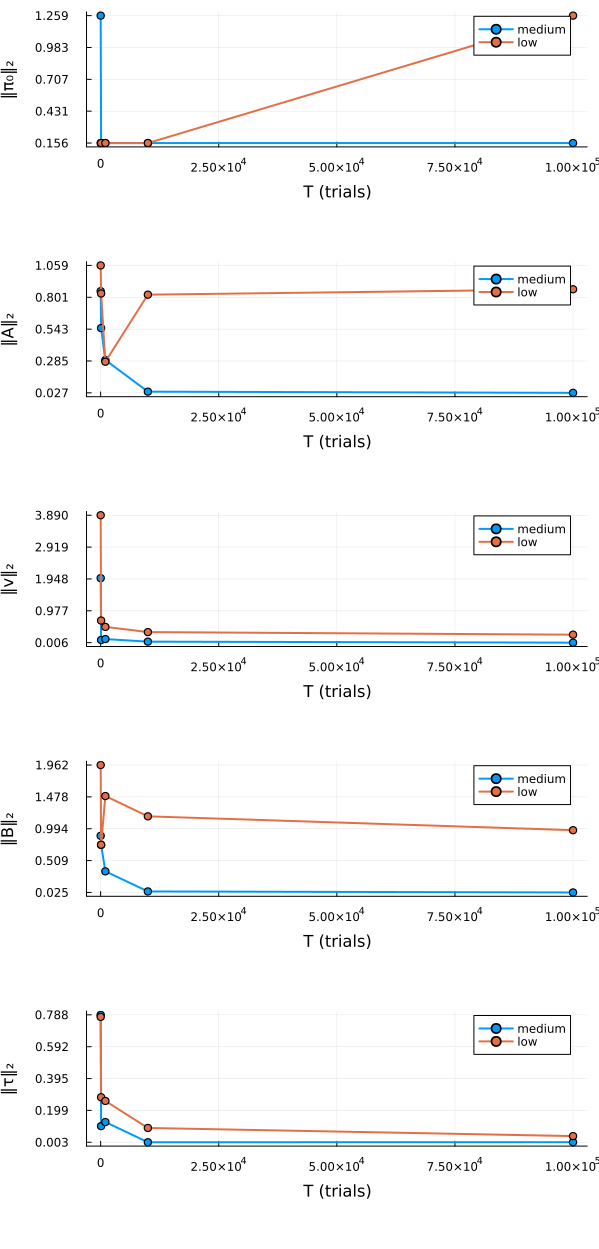

"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/data/hmm_param_errors.svg"

In [66]:
function plot_param_errors(param_errors::Dict{String, Dict{Int64, Any}})

    all_models = collect(keys(param_errors))
    models = filter(m -> m != "high", all_models)  # Exclude "high"
    time_lengths = sort(unique(vcat([collect(keys(param_errors[m])) for m in models]...)))

    # Use L2-norm notation
    param_keys = ["π₀_L2", "A_L2", "v_L2", "B_L2", "τ_L2"]
    param_labels = Dict(
        "π₀_L2" => "‖π₀‖₂",
        "A_L2" => "‖A‖₂",
        "v_L2" => "‖v‖₂",
        "B_L2" => "‖B‖₂",
        "τ_L2" => "‖τ‖₂"
    )

    # Prepare data
    data = Dict{String, Dict{String, Vector{Float64}}}()
    for param in param_keys
        inner_dict = Dict{String, Vector{Float64}}()
        for model in models
            inner_dict[model] = [get(param_errors[model][t], param, NaN) for t in time_lengths]
        end
        data[param] = inner_dict
    end

    # Plot layout and appearance
    n = length(param_keys)
    plt = plot(layout = (n, 1), size = (600, 250 * n),
               bottom_margin = 10Plots.mm, left_margin = 8Plots.mm, xlabel="T (trials)")

    for (i, param) in enumerate(param_keys)
        all_vals = vcat([data[param][model] for model in models]...)
        miny, maxy = minimum(all_vals), maximum(all_vals)
        yticks_pos = range(miny, maxy, length=5)
        yticks_lab = [@sprintf("%.3f", y) for y in yticks_pos]

        for model in models
            plot!(plt[i], time_lengths, data[param][model],
                  label = model,
                  lw = 2,
                  marker = :circle,
                  ylabel = param_labels[param],
                  yticks = (collect(yticks_pos), yticks_lab),
                  legend = :topright)
        end
    end

    display(plt)
    return plt
end


plut = plot_param_errors(param_errors)
savefig(plut, "../data/hmm_param_errors.svg")

In [80]:
hmm_learned = learned_model_dict["medium"][10000][1]
posterior, _ = forward(hmm_learned, data_dict["medium"][10000][2])
est_posterior = Vector{Int}(ones(10000))
state_2_trials = [i for i in 1:10000 if posterior[2, i] .> 0.5]
est_posterior[state_2_trials] .= 2
predicted_data = (data_dict["medium"][10000][2], est_posterior)


data_dict["medium"][10000]
true_data = (data_dict["medium"][10000][2], data_dict["medium"][10000][1])

(DDMResult[DDMResult(2.746280000029965, 1), DDMResult(0.8469590000035174, 1), DDMResult(1.182747999992884, 1), DDMResult(0.8005300000021823, 1), DDMResult(2.170968999949549, 1), DDMResult(2.02903499992971, 1), DDMResult(1.1074349999990798, 1), DDMResult(0.749259000000708, 1), DDMResult(5.061037000353517, 1), DDMResult(1.055029000003391, -1)  …  DDMResult(1.4490219999709786, 1), DDMResult(0.822289000002808, 1), DDMResult(2.3667979999769218, -1), DDMResult(5.030491000349247, 1), DDMResult(1.4856619999679643, 1), DDMResult(2.290064999966196, 1), DDMResult(1.5537809999623604, 1), DDMResult(2.3660789999768213, -1), DDMResult(2.3896409999801147, -1), DDMResult(1.4007409999749505, 1)], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [88]:
function state_dependent_histogram(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 n_bins::Int=100)

    default(guidefontsize=16, tickfontsize=14, legendfontsize=14)
    
    # Unpack the data
    true_results, true_states = true_data
    sim_results, sim_states = simulated_data
    
    # Create empty plots
    p1 = plot(title="State 1 Response Times", xlabel="RT (s)", ylabel="Density")
    p2 = plot(title="State 2 Response Times", xlabel="RT (s)", ylabel="Density")
    
    # Stratify data by state and correctness
    # State 1
    state1_true_idx = findall(x -> x == 1, true_states)
    state1_sim_idx = findall(x -> x == 1, sim_states)
    
    state1_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == 1]
    state1_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == -1]
    
    state1_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == 1]
    state1_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == -1]
    
    # State 2
    state2_true_idx = findall(x -> x == 2, true_states)
    state2_sim_idx = findall(x -> x == 2, sim_states)
    
    state2_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == 1]
    state2_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == -1]
    
    state2_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == 1]
    state2_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == -1]
    
    # Handle case where arrays might be empty
    if isempty(state1_true_correct) && isempty(state1_true_error) && 
       isempty(state1_sim_correct) && isempty(state1_sim_error) &&
       isempty(state2_true_correct) && isempty(state2_true_error) && 
       isempty(state2_sim_correct) && isempty(state2_sim_error)
        return plot(title="No data available")
    end
    
    # Find common RT range for appropriate binning
    all_rts = vcat(
        state1_true_correct, state1_true_error, state1_sim_correct, state1_sim_error,
        state2_true_correct, state2_true_error, state2_sim_correct, state2_sim_error
    )
    
    min_rt = minimum(all_rts)
    max_rt = maximum(all_rts)
    rt_range = (min_rt, max_rt)
    
    # Calculate histogram data manually
    # Create the bins
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)
    
    # Function to compute histogram heights
    function compute_hist_heights(data, normalize=true)
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        heights = hist.weights
        if normalize
            heights = heights ./ (sum(heights) * bin_width)
        end
        return heights
    end
    
    # Compute histogram heights for all datasets
    s1_true_correct_heights = compute_hist_heights(state1_true_correct)
    s1_true_error_heights = compute_hist_heights(state1_true_error)
    s1_sim_correct_heights = compute_hist_heights(state1_sim_correct)
    s1_sim_error_heights = compute_hist_heights(state1_sim_error)
    
    s2_true_correct_heights = compute_hist_heights(state2_true_correct)
    s2_true_error_heights = compute_hist_heights(state2_true_error)
    s2_sim_correct_heights = compute_hist_heights(state2_sim_correct)
    s2_sim_error_heights = compute_hist_heights(state2_sim_error)
    
    # Plot histograms using bar plots
    # State 1 - Correct trials (positive y-axis)
    bar!(p1, bin_centers, s1_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, s1_sim_correct_heights, 
        label="Simulated Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 1 - Error trials (negative y-axis)
    bar!(p1, bin_centers, -s1_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, -s1_sim_error_heights, 
        label="Simulated Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Correct trials (positive y-axis)
    bar!(p2, bin_centers, s2_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, s2_sim_correct_heights, 
        label="Predicted Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Error trials (negative y-axis)
    bar!(p2, bin_centers, -s2_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, -s2_sim_error_heights, 
        label="Predicted Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # Add horizontal line at y=0
    hline!(p1, [0], color=:black, linestyle=:dash, label=nothing)
    hline!(p2, [0], color=:black, linestyle=:dash, label=nothing)
    
    # Manually set y-ticks with absolute values as labels
    # Find the maximum y value (positive or negative) to set symmetric ticks
    max_y1 = max(
        maximum(s1_true_correct_heights), 
        maximum(s1_sim_correct_heights),
        maximum(s1_true_error_heights),
        maximum(s1_sim_error_heights)
    )
    
    max_y2 = max(
        maximum(s2_true_correct_heights), 
        maximum(s2_sim_correct_heights),
        maximum(s2_true_error_heights),
        maximum(s2_sim_error_heights)
    )
    
    # Create symmetric tick positions
    y_ticks1 = collect(range(-max_y1, max_y1, length=7))
    y_ticks2 = collect(range(-max_y2, max_y2, length=7))

    # Format tick labels with restricted significant figures (2 decimal places)
    format_tick(y) = @sprintf("%.2f", abs(y))

    # Set ticks with formatted absolute values as labels
    yticks!(p1, y_ticks1, [format_tick(y) for y in y_ticks1])
    yticks!(p2, y_ticks2, [format_tick(y) for y in y_ticks2])
    
    # Add annotations 
    max_correct_height1 = maximum(s1_true_correct_heights)
    max_error_height1 = maximum(s1_true_error_heights)
    
    max_correct_height2 = maximum(s2_true_correct_heights)
    max_error_height2 = maximum(s2_true_error_heights)
    
    # Create combined plot
    combined_plot = plot(p1, p2, layout=(2,1), size=(1100, 800), legend=:topright)
    
    return combined_plot
end

state_dependent_histogram (generic function with 2 methods)

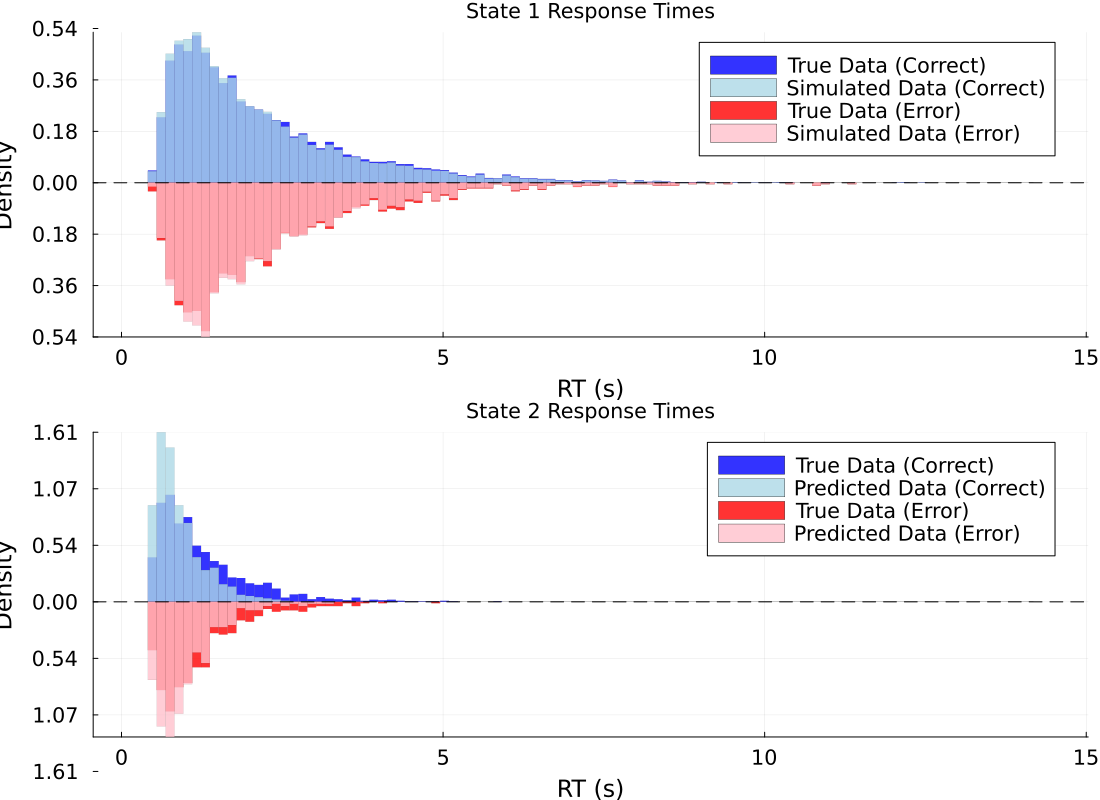

In [90]:
comb_plot = state_dependent_histogram(true_data, predicted_data)
# savefig(comb_plot, "../data/hmm_state_dependent_histogram.svg")